# Price Prediction For Skincare Products Using Neural Networks

## Overview

The cosmetics industry brought in an estimated $262.21 billion in 2022 and is due to continue growing this year. Skincare in particular has seen an increased interest as the culture has shifted away from the glam beauty standards of the recession-era 2000s to embrace a more "natural" beauty. 

My stakeholder, Inner Glow Inc., wants to make their mark on the skincare industry by coming out with their own line of products that are competetive with what's available. To do this, they first need to understand the current market and determine where they can undercut more expensive alternatives. Rampant upcharge in the skincare industry is obvious when products can range from $7-400. How can Inner Glow Inc. offer mid-line products that capture both a high-end and low-end market?

Using neural networks and XGBoost, I look at data from NoxMoon's "Inside Beauty" project, scraped from Beautypedia and Paula’s choice websites, and data I scraped myself from the Dermstore. The two datasets include product names, brands, prices, ingredients, size, and product type. There are over 7000 products at the end of cleaning. Features include one-hot encoded "special" ingredients (i.e. not ones that appear in every single product but do in a good amount of them), and number of active and inactive ingredients, among others.

After tuning a series of neural networks, using XGBoost, and using grid search to tune XGBoost, I find in the end that the untuned XGBoost does the best with the data, scoring an MAE on the test around $13. Given the spread of product prices, this doesn't seem way off base. Features engineering determines certain ingredients, like Isopropyl Misorate, have a marginal level of importance when it comes to price. The most often overpriced brands are iS Clinical, Clarins, and SK-II, while the most underpriced ones are Neutrogena, Clinique, and L'Oreal Paris. Therefore, Inner Beauty Inc. should try to dupe the overpriced brands' products with prices that are on average higher than the underpriced ones.

I put all these findings together into the Streamlit app SuperDuper which offers users the chance to dupe their favorite high-end products and find cheaper alternatives that are at the ingredient-level similar.

## Imports

To begin, we import all our libraries.

In [1]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

## EDA

The data comes from Beautypedia and Paula's Choice (scraped by NoxMoon on GitHub) and from the Dermstore. You can see my scraping code for the Dermstore in the web_scraping folder. Both datasets include product names, prices, categories, brands, and ingredients.

In [2]:
# read NoxMoon's data
df1 = pd.read_csv("data/skin_care_cleaned.csv")
df1 = df1[["product_names", "product_category", "brand", "ingredient", "size", "price", "size_num", "size_unit", 
        'active_ingredient', 'inactive_ingredient', 'n_inactive_ingredient', 'n_active_ingredient']]

# basic cleaning for readability, dropping empty cells
df1.active_ingredient = df1.active_ingredient.str.replace("(", "")
df1.active_ingredient = df1.active_ingredient.str.replace(")", "")
df1.active_ingredient = df1.active_ingredient.str.replace(",", "")
df1.active_ingredient = df1.active_ingredient.str.replace("%.", "%")
df1.active_ingredient = df1.active_ingredient.str.strip()
df1.active_ingredient = df1.active_ingredient.str.split("%")
df1 = df1.dropna(subset=["ingredient", "size", "size_unit"])

In [3]:
df1.head()

,product_names,product_category,brand,ingredient,size,price,size_num,size_unit,active_ingredient,inactive_ingredient,n_inactive_ingredient,n_active_ingredient
0,Clear Complexion Spot Treatment,Acne & Blemish Treatment,Merle Norman,"Active: Salicylic Acid (2%), Other: Alcohol D...",0.50 fl. oz.,20.00,15.0,ml,"[Salicylic Acid 2, ]","Alcohol Denat., Hamamelis Virginiana (Witch ...",10,1
1,Acne Solutions Emergency Gel Lotion,Acne & Blemish Treatment,Clinique,"Active: Benzoyl Peroxide (5%), Other: Water P...",0.50 fl. oz.,17.00,15.0,ml,"[Benzoyl Peroxide 5, ]","Water Purified, C12-15 Alkyl Benzoate, Glyc...",23,1
2,RESIST Daily Pore-Refining Solution 2% BHA,Acne & Blemish Treatment,Paula's Choice Skincare,"Water (Aqua), Dipropylene Glycol, Salicylic ...",3.00 fl. oz.,33.00,89.0,ml,NaN,"Water (Aqua), Dipropylene Glycol, Salicylic ...",26,0
4,Naturals Acne Spot Treatment,Acne & Blemish Treatment,Neutrogena,Active Ingredient: Salicylic Acid 1%. Inactive...,0.75 fl. oz.,8.49,22.0,ml,"[Salicylic Acid 1, ]","Water, Hydrated Silica, Glycerin, Dicapryl...",18,1
5,Normaderm Daily Anti-Acne Hydrating Lotion,Acne & Blemish Treatment,Vichy,"Active: Salicylic Acid 1%. Inactive: Water, G...",1.70 fl. oz.,23.50,50.0,ml,"[Salicylic Acid 1, ]","Water, Glycerin, Alcohol Denat., Phenyl Tr...",24,1


In [4]:
# read in Dermstore data
df2 = pd.read_csv("data/ingredients_skincare_dermstore.csv").drop(columns = ["Unnamed: 0", "url"])

# remove dollar signs from dataframe
df2["price"] = df2["price"].str.replace("$", "")
df2.head()

,product_name,brand,price,ingredients,active_ingredients,inactive_ingredients
0,ELEMIS Pro-Collagen Cleansing Balm (100 g.),Elemis,68.00,"Prunus Amygdalus Dulcis (Sweet Almond) Oil, Ca...",NaN,NaN
1,VIRTUE Healing Oil (1.7 fl. oz.),VIRTUE,44.00,"Alpha Keratin 60ku®, Cyclopentasiloxane, Dimet...",Alpha Keratin 60ku®,"Cyclopentasiloxane, Dimethiconol, Parfum (Frag..."
2,Augustinus Bader The Rich Cream 50ml,Augustinus Bader,290.00,"Aqua (Water), Coco-Caprylate/Caprate, Helianth...",NaN,NaN
3,SkinCeuticals C E Ferulic (1 fl. oz.),SkinCeuticals,182.00,"Aqua/Water/Eau, Ethoxydiglycol, Ascorbic Acid,...",NaN,NaN
4,U Beauty Resurfacing Compound 50ml /1.7 oz,U Beauty,228.00,"Aqua (Water), Aloe Barbadensis Leaf Juice Powd...",NaN,NaN


Both datasets seem to be missing data for active ingredients, and the second dataset is missing data for inactive ingredients. This might be because not all products have active and inactive ingredient distinctions.

Let's look at the range of prices. First we'll need to remove rows where the price data isn't a number. And then we'll need to convert the prices to floats.

In [5]:
# find and drop irregular rows
index_list = []
for index, row in df2.iterrows():
    if "-product" in str(row["price"]):
        index_list.append(index)
    elif "-qubit" in str(row["price"]):
        index_list.append(index)
    elif "-track" in str(row["price"]):
        index_list.append(index)
        
df2 = df2.drop(index = index_list)

# convert price column to float
df2["price"] = df2["price"].astype(float)

# put the dataframes together
df = pd.concat([df1, df2])

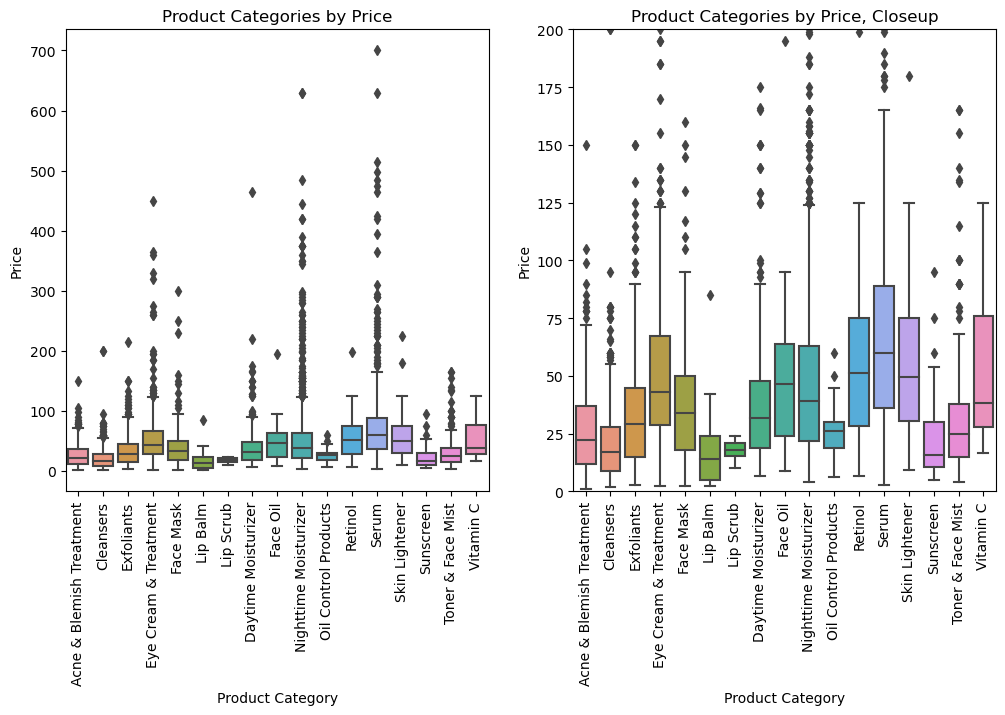

In [6]:
# plot the prices by product category
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
sns.boxplot(x='product_category', y='price', data=df, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_xlabel("Product Category")
axs[0].set_ylabel("Price")
axs[0].set_title("Product Categories by Price")

sns.boxplot(x='product_category', y='price', data=df, ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[1].set_xlabel("Product Category")
axs[1].set_ylabel("Price")
axs[1].set_title("Product Categories by Price, Closeup")
axs[1].set_ylim(0, 200);

So, the majority of products average less than $50, while serums tick higher than the others. There are probably more designer products in the serum category than the others. Lip balms and scrubs seem to be the cheapest items. There are also many outliers that tick even higher than these averages (left plot).

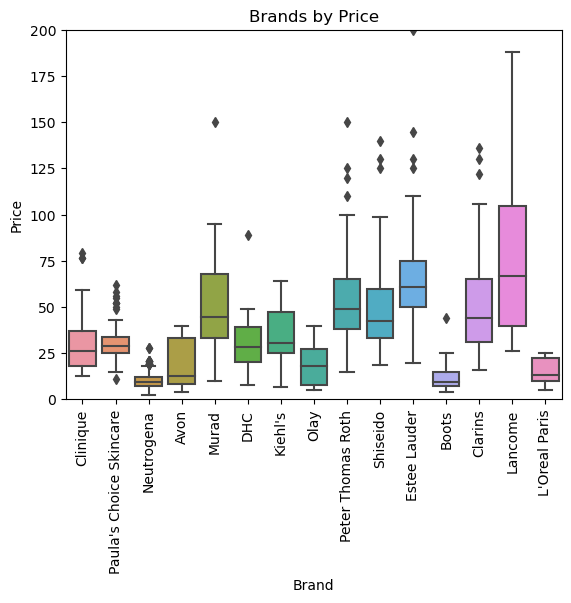

In [7]:
# select most common brands
brand_list = []
for key, value in df.brand.value_counts().head(16).to_dict().items():
    brand_list.append(key)

df_topbrands = df[df["brand"].isin(brand_list)]
df_topbrands = df_topbrands[["brand", "price", "product_names"]]
df_topbrands = df_topbrands.dropna()

# plot brands against price
ax = sns.boxplot(x='brand', y='price', data=df_topbrands)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Brand")
ax.set_ylabel("Price")
ax.set_title("Brands by Price")
ax.set_ylim(0, 200);

Lancome has tthe greatest spread of prices amongst its catalog, while Neutrogena has the smallest. Neutrogena also seems to be the cheapest.

Since brands and product categories seem to be a great determinant of price, there's a good chance both will show up in the features engineering portion of this notebook.

## Data Preparation
In order to seamlessly combine the datasets, we'll need to do some cleaning. We'll go back to dfs 1 and 2 to do this. It'll also help us to turn our ingredient columns into lists for one-hot encoding.

In [8]:
# some cleaning
# turn active ingredients into list, input inactive ingredients
df2["active_ingredients"] = df2["active_ingredients"].str.split(",")
df2["inactive_ingredients"] = df2["inactive_ingredients"].fillna(df2["ingredients"])

# create and fill n_active_ingredient column
df2["n_active_ingredient"] = df2["active_ingredients"]
df2["n_active_ingredient"] = df2["n_active_ingredient"].fillna(0)
for index, row in df2.iterrows():
    if type(row["n_active_ingredient"]) == list:
        if len(row["n_active_ingredient"]) > 0:
            row["n_active_ingredient"] = len(row["n_active_ingredient"])
            
# create and fill n_inactive_ingredient column
df2["n_inactive_ingredient"] = df2["inactive_ingredients"].str.split(",")
for index, row in df2.iterrows():
    if type(row["n_inactive_ingredient"]) == list:
        if len(row["n_inactive_ingredient"]) > 0:
            row["n_inactive_ingredient"] = len(row["n_inactive_ingredient"])

Df2 doesn't have product categories, like df1 does. We'll have to semi-manually create these based on keywords.

In [9]:
# create product categories for items
df2["product_category"] = df2["product_name"]
for index, row in df2.iterrows():
    if "Serum" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Hydr" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Refi" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Bar" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Stem" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Neck" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "neck" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Peptide" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Resurfac" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Collagen" in row["product_category"]:
        row["product_category"] = "Serum"
    elif "Sun" in row["product_category"]:
        row["product_category"] = "Sunscreen" 
    elif "SPF" in row["product_category"]:
        row["product_category"] = "Sunscreen" 
    elif "Clean" in row["product_category"]:
        row["product_category"] = "Cleansers"
    elif "Wash" in row["product_category"]:
        row["product_category"] = "Cleansers"
    elif "Wipes" in row["product_category"]:
        row["product_category"] = "Cleansers"
    elif "Pads" in row["product_category"]:
        row["product_category"] = "Cleansers" 
    elif "Makeup Remover" in row["product_category"]:
        row["product_category"] = "Cleansers"
    elif "Soap" in row["product_category"]:
        row["product_category"] = "Cleansers" 
    elif "Cream" in row["product_category"]:
        row["product_category"] = "Nighttime Moisturizer"
    elif "Creme" in row["product_category"]:
        row["product_category"] = "Nighttime Moisturizer"
    elif "Night" in row["product_category"]:
        row["product_category"] = "Nighttime Moisturizer"
    elif "night" in row["product_category"]:
        row["product_category"] = "Nighttime Moisturizer"
    elif "Nuit" in row["product_category"]:
        row["product_category"] = "Nighttime Moisturizer"
    elif "Gel" in row["product_category"]:
        row["product_category"] = "Nighttime Moisturizer"
    elif "Sleep" in row["product_category"]:
        row["product_category"] = "Nighttime Moisturizer"
    elif "Lotion" in row["product_category"]:
        row["product_category"] = "Daytime Moisturizer"
    elif "Moisturizer" in row["product_category"]:
        row["product_category"] = "Daytime Moisturizer"
    elif "Butter" in row["product_category"]:
        row["product_category"] = "Daytime Moisturizer"
    elif "Lip" in row["product_category"]:
        row["product_category"] = "Lip Scrub"
    elif "Mask" in row["product_category"]:
        row["product_category"] = "Face Mask"
    elif "Masque" in row["product_category"]:
        row["product_category"] = "Face Mask"
    elif "Acne" in row["product_category"]:
        row["product_category"] = "Acne & Blemish Treatment"
    elif "Blemish" in row["product_category"]:
        row["product_category"] = "Acne & Blemish Treatment"
    elif "Pore" in row["product_category"]:
        row["product_category"] = "Acne & Blemish Treatment"
    elif "Spot" in row["product_category"]:
        row["product_category"] = "Acne & Blemish Treatment"
    elif "Clinical" in row["product_category"]:
        row["product_category"] = "Acne & Blemish Treatment"
    elif "System" in row["product_category"]:
        row["product_category"] = "Acne & Blemish Treatment"
    elif "Treatment" in row["product_category"]:
        row["product_category"] = "Acne & Blemish Treatment"
    elif "Eye" in row["product_category"]:
        row["product_category"] = "Eye Cream & Treatment" 
    elif "Toner" in row["product_category"]:
        row["product_category"] = "Toner & Face Mist"
    elif "Mist" in row["product_category"]:
        row["product_category"] = "Toner & Face Mist"
    elif "mist" in row["product_category"]:
        row["product_category"] = "Toner & Face Mist" 
    elif "Scrub" in row["product_category"]:
        row["product_category"] = "Exfoliants"
    elif "Exfoli" in row["product_category"]:
        row["product_category"] = "Exfoliants" 
    elif "Polish" in row["product_category"]:
        row["product_category"] = "Exfoliants"
    elif "Glow" in row["product_category"]:
        row["product_category"] = "Exfoliants"
    elif "Peel" in row["product_category"]:
        row["product_category"] = "Exfoliants"
    elif "Vitamin C" in row["product_category"]:
        row["product_category"] = "Vitamin C"
    elif "Vita C" in row["product_category"]:
        row["product_category"] = "Vitamin C"
    elif "Refin" in row["product_category"]:
        row["product_category"] = "Vitamin C"
    elif "Bright" in row["product_category"]:
        row["product_category"] = "Skin Lightener"
    elif "-C" in row["product_category"]:
        row["product_category"] = "Vitamin C"
    elif "Vit C" in row["product_category"]:
        row["product_category"] = "Vitamin C"
    elif "- C" in row["product_category"]:
        row["product_category"] = "Vitamin C"
    elif "Oil" in row["product_category"]:
        row["product_category"] = "Facial Oil" 
    elif "Retinol" in row["product_category"]:
        row["product_category"] = "Retinol" 
    elif "Matt" in row["product_category"]:
        row["product_category"] = "Oil Control Products" 
        
product_types = ["Nighttime Moisturizer", "Cleansers", "Serum", "Exfoliants", "Eye Cream & Treatment", "Daytime Moisturizer",
                "Sunscreen", "Toner & Face Mist", "Face Mask", "Acne & Blemish Treatment", "Lip Balm", "Retinol",
                "Skin Lightener", "Oil Control Products", "Face Oil", "Vitamin C", "Lip Scrub"]
df2 = df2.loc[df2["product_category"].isin(product_types)]

Now we need to create and clean up our size columns.

In [10]:
# make and fill size_num column
pattern = r'(\d+(\.\d+)?)\s*(fl\.?\s*oz\.?|g\.?|ml\.?)'
extracted_values = df2["product_name"].str.extract(pattern, expand=True).fillna("")
df2["size_num"] = extracted_values.iloc[:, 0]


# make and fill size_unit column
df2["size_unit"] = df2["product_name"]
for index, row in df2.iterrows():
    if "g." in row["size_unit"]:
        row["size_unit"] = "grams"
    elif "fl. oz" in row["size_unit"]:
        row["size_unit"] = "fluid ounces"
    elif "ml" in row["size_unit"]:
        row["size_unit"] = "milliliters"
    else:
        row["size_unit"] = "piece/other"

# make and fill a size column
df2["size"] = df2["size_num"] + " " + df2["size_unit"]
df2["size"] = df2["size"].str.replace("grams", "g.")
df2["size"] = df2["size"].str.replace("milliliters", "ml")
df2["size"] = df2["size"].str.replace("fluid ounces", "fl. oz.")

In [11]:
# remove unnecessary columns and make names uniform
df2 = df2[["product_name", "product_category", "brand", "ingredients", "size", "price", "size_num", "size_unit", 
          "active_ingredients", "inactive_ingredients", "n_inactive_ingredient", "n_active_ingredient"]]
df2.columns = ['product_names', 'product_category', 'brand', 'ingredient', 'size', 'price', 'size_num', 'size_unit', 
               'active_ingredient', 'inactive_ingredient', 'n_inactive_ingredient', 'n_active_ingredient']

In [12]:
# clean up active ingredient column
df2["active_ingredient"] = df2["active_ingredient"].astype(str)
df2["active_ingredient"] = df2["active_ingredient"].str.replace("'", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace("[", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace("]", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace("<strong>Active: </strong>", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace("<strong>Active Ingredients:</strong>", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace("Active Ingredients: ", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace("\n", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace("%", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace(")", "")
df2["active_ingredient"] = df2["active_ingredient"].str.replace("(", "")

In [13]:
# join dataframes
df = pd.concat([df1, df2]).reset_index().drop(columns = "index")
df.head()

,product_names,product_category,brand,ingredient,size,price,size_num,size_unit,active_ingredient,inactive_ingredient,n_inactive_ingredient,n_active_ingredient
0,Clear Complexion Spot Treatment,Acne & Blemish Treatment,Merle Norman,"Active: Salicylic Acid (2%), Other: Alcohol D...",0.50 fl. oz.,20.00,15.0,ml,"[Salicylic Acid 2, ]","Alcohol Denat., Hamamelis Virginiana (Witch ...",10,1
1,Acne Solutions Emergency Gel Lotion,Acne & Blemish Treatment,Clinique,"Active: Benzoyl Peroxide (5%), Other: Water P...",0.50 fl. oz.,17.00,15.0,ml,"[Benzoyl Peroxide 5, ]","Water Purified, C12-15 Alkyl Benzoate, Glyc...",23,1
2,RESIST Daily Pore-Refining Solution 2% BHA,Acne & Blemish Treatment,Paula's Choice Skincare,"Water (Aqua), Dipropylene Glycol, Salicylic ...",3.00 fl. oz.,33.00,89.0,ml,NaN,"Water (Aqua), Dipropylene Glycol, Salicylic ...",26,0
3,Naturals Acne Spot Treatment,Acne & Blemish Treatment,Neutrogena,Active Ingredient: Salicylic Acid 1%. Inactive...,0.75 fl. oz.,8.49,22.0,ml,"[Salicylic Acid 1, ]","Water, Hydrated Silica, Glycerin, Dicapryl...",18,1
4,Normaderm Daily Anti-Acne Hydrating Lotion,Acne & Blemish Treatment,Vichy,"Active: Salicylic Acid 1%. Inactive: Water, G...",1.70 fl. oz.,23.50,50.0,ml,"[Salicylic Acid 1, ]","Water, Glycerin, Alcohol Denat., Phenyl Tr...",24,1


The size of the product is often determined by the type of product it is – as in, moisturizer and sunscreen might be larger than serums. But there's a range even within these, depending on the brand. As a result, we'll keep size details in the dataframe without concern for collinearity.

In [14]:
# turn inactive ingredient column into lists
df["inactive_ingredient"] = df["inactive_ingredient"].str.replace(".", "")
df["inactive_ingredient"] = df["inactive_ingredient"].str.replace(" ", "")
df["inactive_ingredient"] = df["inactive_ingredient"].str.split(",")

Now we want to one-hot encode and stack our ingredients.

In [15]:
# get ingredient counts
ingredients_df = pd.get_dummies(pd.DataFrame(df["inactive_ingredient"].tolist()).stack()).sum(level=0)
ingredients_df.shape

(4816, 12507)

Most products will have the same base ingredients. To ensure our model is determing price based on "special" ingredients or uncommon (but not impossibly rare) ingredients, we'll limit the set to ingredients that show up between 100 and 800 times.

In [16]:
# determine most important ingredients
ing_list = []
for column in ingredients_df.columns:
    if ingredients_df[column].sum() > 100 and ingredients_df[column].sum() < 800:
        ing_list.append(column)

ing_list = [ele.strip() for ele in ing_list]

# get rid of empty string
ing_list = ing_list[1:]

In [17]:
# create dataframe from columns in ing_list
ingredients_df = ingredients_df.rename(columns=lambda x: x.strip())
clean_ing = ingredients_df[ing_list]

# concat dataframes
df_ing = pd.concat([df, clean_ing], axis = 1)
df_ing.shape

(4816, 205)

Now our dataframe is looking more manageable with only 205 columns as opposed to nearly 13,000.

In [18]:
# remove duplicate columns
df_ing = df_ing.groupby(axis=1, level=0).sum()

In [19]:
# make sure our float columns are floats
df_ing["price"] = df_ing["price"].astype(float)
df_ing["size_num"] = df_ing["size_num"].replace(r'^\s*$', np.nan, regex=True)
df_ing["size_num"] = df_ing["size_num"].astype(float)

## Preprocess Data

Let's build the preprocessor our XGBoost regressor will use.

In [20]:
#ord_cols
ord_cols = ["brand", "product_category", "size_unit"]

#num_cols
num_cols = ["size_num", "n_active_ingredient", "n_inactive_ingredient"]
ingredients = df_ing.columns.to_list()[:-12]
for ing in ingredients:
    num_cols.append(ing)

In [21]:
ordinal_transformer = Pipeline(steps = [
    ('ordimputer', SimpleImputer(strategy = 'most_frequent')),
    ('target_enc', TargetEncoder()),
    ("scaler", StandardScaler())])

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ("ord", ordinal_transformer, ord_cols),
        ("num", numeric_transformer, num_cols),
    ]
)

## Train-Test Split

Time for the train-test split.

In [22]:
y = df_ing["price"]
X = df_ing.drop(columns = ["price", "active_ingredient", "inactive_ingredient", "ingredient", "product_names", "size"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [23]:
X_train

,2-Hexanediol,AcetylGlucosamine,AcetylHexapeptide-8,Acrylates/C10-30AlkylAcrylateCrosspolymer,AcrylatesCopolymer,Adenosine,Alcohol,AlcoholDenat,AlgaeExtract,Allantoin,...,Xylitol,YeastExtract,Yellow5,ZincGluconate,brand,n_active_ingredient,n_inactive_ingredient,product_category,size_num,size_unit
2586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,Mario Badescu,3,21,Daytime Moisturizer,59.0,ml
2818,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,Laneige,0,45,Nighttime Moisturizer,98.0,ml
2882,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,L'Oreal Paris,0,42,Nighttime Moisturizer,50.0,ml
1647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,MD Formulations,0,36,Eye Cream & Treatment,15.0,ml
2638,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,The Ordinary,0,46,Nighttime Moisturizer,30.0,ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,Clarins,5,40,Sunscreen,74.0,ml
466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,Clinique,0,22,Cleansers,198.0,ml
3092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,Kiss My Face,0,31,Nighttime Moisturizer,473.0,ml
3772,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,Chantecaille,0,33,Serum,50.0,ml


Just to check, let's see what the MAE is before modeling.

In [24]:
# determine baseline error
mae_train = mean_absolute_error(y_train, np.ones([y_train.shape[0],])* y_train.median())
mae_test = mean_absolute_error(y_test, np.ones([y_test.shape[0],])* y_train.median())

print("MAE")
print(f"train: {mae_train:.3f}") 
print(f"test: {mae_test:.3f}")

MAE
train: 26.585
test: 27.231


Right now, we have a mean absolute error of almsot $30 for both train and test. This is what we'll want to beat with our models.

# Modeling
## Model 1 - Simple Regressor

Before diving into neural networks, let's see how our tried and tested XGBoost does with the data.

In [25]:
# instantiate, fit and run model
X_train_ct = preprocessor.fit_transform(X_train, y_train)
boost = XGBRegressor()
boost.fit(X_train_ct, y_train)
pred_train_boost = boost.predict(X_train_ct)

X_test_ct = preprocessor.transform(X_test)
pred_test_boost = boost.predict(X_test_ct)

In [26]:
# determine error
mae_train = mean_absolute_error(y_train, pred_train_boost)
mae_test = mean_absolute_error(y_test, pred_test_boost)

print("MAE: ")
print(f"train: {mae_train:.3f}")
print(f"test: {mae_test: .3f}")

MAE: 
train: 3.671
test:  13.139


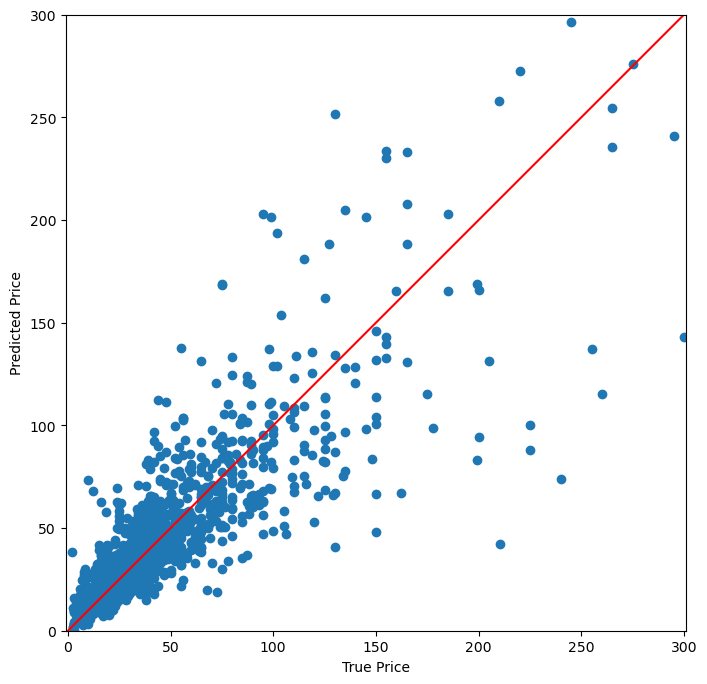

In [27]:
# plot predictions against true prices
plt.figure(figsize=(8,8))
plt.scatter(y_test, pred_test_boost)
plt.plot([0,300],[0,300],color="r")
plt.axis("Equal")
plt.xlim(0,300)
plt.ylim(0,300)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.show()

Not bad! Only about 13 dollars off on average. There is a pretty big range in the products, as we saw above, with some going as high as 700 dollars. 13 dollars seems pretty good with that in mind. Looking at the predictions when plotted, they seem to be clustered pretty well around the equal line though a few seem either overpriced or underpriced based on the model's determination.

Since our simple regressor did pretty well. Let's try to do a grid search to further tune the model and see how that does.

## Model 2 - Grid Search

We'll tune the model with a range of learning rates, estimators, and depths to see how it does.

In [ ]:
# parameter grid
param_grid = {
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],
    "n_estimators": [100, 250, 500, 750, 1000],
    "max_depth": [3, 5, 7, 9, 11]
}


# instantiate and fit
boost = XGBRegressor()
grid_search = GridSearchCV(boost, param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X_train_ct, y_train)

# return best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# get predictions off best model
best_boost = grid_search.best_estimator_
pred_test_boost_gs = best_boost.predict(X_test_ct)

In [ ]:
# plot predictions against true prices
plt.figure(figsize=(7,7))
plt.scatter(y_test, pred_test_boost_gs)
plt.plot([0,300],[0,300],color="r")
plt.axis("Equal")
plt.xlim(0,300)
plt.ylim(0,300)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.show()

## Model 3: Stacked Regressor

We can go further with regressors and stack them together to see if that improves our score.

In [ ]:
boost = XGBRegressor()
rf = RandomForestRegressor()
ridge = Ridge()
lasso = Lasso()
svr = SVR(kernel='linear')

stack = StackingCVRegressor(regressors=(boost, rf, ridge, lasso, svr),
                            meta_regressor=boost, cv=5,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False,
                            random_state=42)

stack.fit(X_train_ct, y_train)
pred_stack = stack.predict(X_test_ct)
mae_test = mean_absolute_error(y_test, pred_stack)

print("MAE: ")
print(f"test: {mae_test: .3f}")

In [ ]:
# plot predictions against true prices
plt.figure(figsize=(7,7))
plt.scatter(y_test, pred_stack)
plt.plot([0,300],[0,300],color="r")
plt.axis("Equal")
plt.xlim(0,300)
plt.ylim(0,300)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.show()

Not a lot of improvement from our untuned XGBoost. On to the neural networks to see if they can do more.

## Model 4 - Neural Network, 3 Hidden Layers

For the first neural network, we'll start simple with 3 hidden layers and two dropouts.

In [ ]:
X_train_ct = preprocessor.fit_transform(X_train, y_train)
X_test_ct = preprocessor.transform(X_test)

learning_rate = 0.01

model4 = Sequential([
    Dense(520, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(480, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])

mae_k = MeanAbsoluteError()
model4.compile(loss=mae_k, optimizer=Adam(learning_rate=learning_rate), metrics=[mae_k])

model_4 = model4.fit(X_train_ct, y_train, epochs=100, batch_size=64, validation_split=0.2)

In [ ]:
y_train_pred = model4.predict(X_train_ct)
y_test_pred = model4.predict(X_test_ct)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("MAE: ")
print(f"train: {mae_train:.3f}")
print(f"test: {mae_test: .3f}")

The Neural Network didn't improve upon the XGBoost regressor MAE score. In fact it's gone up by a point, more than our stacked model or the gridsearch tuned XGBoost. Maybe more layers will help.

## Model 4 - Neural Network, 5 Hidden Layers¶

For this model, we'll add more hidden layers.

In [ ]:
learning_rate = 0.01

model5 = Sequential([
    Dense(520, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(480, kernel_initializer='normal', activation='relu'),
    Dense(480, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])

mae_k = MeanAbsoluteError()
model5.compile(loss=mae_k, optimizer=Adam(learning_rate=learning_rate), metrics=[mae_k])

model_5 = model5.fit(X_train_ct, y_train, epochs=100, batch_size=64, validation_split=0.2)

In [ ]:
y_train_pred = model5.predict(X_train_ct)
y_test_pred = model5.predict(X_test_ct)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("MAE: ")
print(f"train: {mae_train:.3f}")
print(f"test: {mae_test: .3f}")

Still no dice. Looks like more layers hurt the MAE score.

## Model 6 - Neural Network, 10 Hidden Layers¶

For the final neural network, we'll try 10 hidden layers to see if that improves the score.

In [ ]:
learning_rate = 0.01

model6 = Sequential([
    Dense(160, kernel_initializer='normal', activation='relu'),
    Dense(160, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(480, kernel_initializer='normal', activation='relu'),
    Dense(480, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(520, kernel_initializer='normal', activation='relu'),
    Dense(520, kernel_initializer='normal', activation='relu'),
    Dense(760, kernel_initializer='normal', activation='relu'),
    Dense(760, kernel_initializer='normal', activation='relu'),
    Dense(760, kernel_initializer='normal', activation='relu'),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])

model6.compile(loss=mae_k, optimizer=Adam(learning_rate=learning_rate), metrics=[mae_k])

model_6 = model6.fit(X_train_ct, y_train, epochs=100, batch_size=64, validation_split=0.2)

In [ ]:
y_train_pred = model6.predict(X_train_ct)
y_test_pred = model6.predict(X_test_ct)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("MAE: ")
print(f"train: {mae_train:.3f}")
print(f"test: {mae_test: .3f}")

This is our worst model so far. Added layers did nothing to improve our score.

## Feature Engineering

Using our baseline XGBoost regressor, let's look at the most important features to see if that will help Inner Beauty Inc. understand where to focus their research and development.

In [ ]:
X_train.columns

In [ ]:
# remember model
X_train_ct = preprocessor.fit_transform(X_train, y_train)
boost = XGBRegressor()
boost.fit(X_train_ct, y_train)

# plot feature importances
features_df = pd.DataFrame()
features_df["feature"] = X_train.columns
features_df["importance"] = boost.feature_importances_
features_df = features_df.sort_values("importance", ascending=False)
plt.figure(figsize=(5,12))
sns.barplot(x = "importance", y = "feature", data=features_df.iloc[:15])
plt.show()

Feature importance seems negligible here since even the most influential feature, the ingredient Urea, is less than 0.1. This might mean that ingredients matter little individually, but mean a lot in groups. Brand and product category don't rank at all, which means they don't have as much influence on price as we originally thought. Size does figure in this chart, which makes sense–a larger product might be more expensive in some cases.

## Over and Under Pricing

It would help Inner Beauty to understand which brands our model considers overpriced or underpriced based in the features. We'll start by creating a dataframe of predicted prices against real prices and then break it down from there.

In [ ]:
# create dataframe of prices and predictions
df_prices = df_ing.loc[y_test.index.to_list()]
df_prices = df_prices[["product_names", "product_category", "brand", "ingredient"]]
df_prices["real_price"] = y_test
df_prices["predicted_price"] = pred_test_boost
df_prices["difference"] = (df_prices["real_price"] - df_prices["predicted_price"]).round(2)

Overpriced we'll define as more than a $20 difference between real and predicted price.

In [ ]:
# find most overpriced brands
overpriced = df_prices.loc[df_prices["difference"] > 20]
overpriced.brand.value_counts().head(10)

La Prairie makes sense as the most overpriced brand as it sells a 1700 dollar perfume among its other products. Its Skin Caviar Luxe Cream alone is almost 600 dollars. Perricone MD Cosmeceuticals and Dr. Brandt are interesting as they are more mid-line brands. 

Underpriced would be any products our model thinks should be more expensive than it is.

In [ ]:
# find most underpriced brands
underpriced = df_prices.loc[df_prices["difference"] < 0]
underpriced.brand.value_counts().head(10)

We have a lot more products in our dataset from the underpriced brands than the overpriced ones. This could be because the overpriced brands have smaller, more exclusive catalogs. Neutrogena and L'Oreal Paris are a drugstore staples, it makes sense they would be at the top of the underpriced list. Shiseido appears on both lists, interestingly enough. Though it has more underpriced products than overpriced ones.

# Dupe Machine

In order to easily understand the paralell products in the dataset, here's a function that returns cheaper products based on inputs. It finds similar products based on ingredients.

In [ ]:
# remove non-essential columns
features = df_ing.copy()
features = features.drop(columns = ["product_names", "size", "size_num", "size_unit", "brand", "active_ingredient", 
                        "inactive_ingredient", "ingredient"])
features = pd.get_dummies(features)

# fit KNN model
model = NearestNeighbors(n_neighbors=2, algorithm='ball_tree')
model.fit(features)
dist, idlist = model.kneighbors(features)

In [ ]:
# define function
def SuperDuper(product_name):
    product_list = []
    product_id = df_ing[df_ing["product_names"] == product_name].index
    product_id = product_id[0]
    product_price = df_ing["price"].iloc[product_id] 
    for newid in idlist[product_id]:
        name = df_ing.loc[newid].product_names
        brand = df_ing.loc[newid].brand
        price = df_ing.loc[newid].price
        price_diff = product_price - price
        if name == product_name:
            pass
        elif price < product_price:
            product_list.append(f"{name} from {brand}, ${price: .2f}, saving ${price_diff: .2f}")
        
    return product_list   

In [ ]:
SuperDuper("Naturals Acne Spot Treatment")

Let's save all of this information for the Streamlit app.

In [ ]:
# creating dataframes and pickles for SuperDuper streamlit app
products_data = df_ing[["brand", "product_names", "price"]]
products_data.to_csv(r"data/products_data.csv")
features.to_pickle("data/features.pkl")

# Conclusions

My recommendation for Inner Beauty Inc is to dupe the overpriced brands with products that undercut their product lines and price them higher than the overpriced brands do to ensure strong margins.

For next steps, it would be useful to go deeper into the ingredients and understand what combinations of ingredients yield the highest prices. Also, packaging signals the quality of the product or at least the price range it operates in. Using image classification might be useful to further the analysis. Finally, Inner Beauty Inc needs to know what product categories to focus on. That would add another element to the analysis.